# EDA and FEATURE EXTRACTION


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob2 import glob
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


In [36]:
meta_df= pd.read_csv('HAM10000_metadata.csv')
print(f"Dataset dimensions: \nRows: {meta_df.shape[0]}\nFeatures: {meta_df.shape[1]}")
meta_df.head()

Dataset dimensions: 
Rows: 10015
Features: 7


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [37]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [38]:
print("Information on dataset\n")
print(meta_df.info())
print("\033[1;32mNull values present in age")

Information on dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None
Null values present in age


In [39]:
# Map lesion_id's to image path
# Map lesion types
df = meta_df.copy()
base_dir= '.'
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_dir, '*', '*.jpg'))}
df['path'] = df['image_id'].map(image_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['dx']).codes

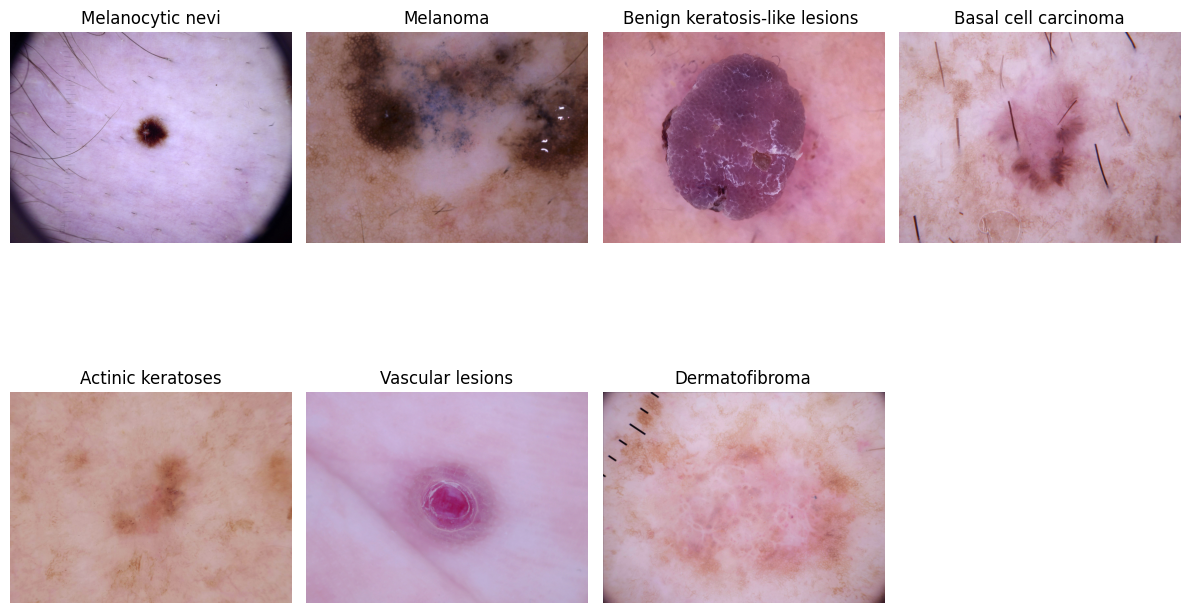

In [58]:
#Plotting the images
plt.figure(figsize=(12, 8)) # Increased figure size for better visualization
for i, (key, cls) in enumerate(lesion_type_dict.items()):
    random_row = df[(df["dx"]==key) & (df["dx_type"]=='histo')].sample(n=1)
    image_path = random_row["path"].iloc[0]
    img = np.array(Image.open(image_path))
    plt.subplot(2,4, i+1)
    plt.imshow(img)
    plt.title(f"{cls}")
    plt.axis('off')
plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

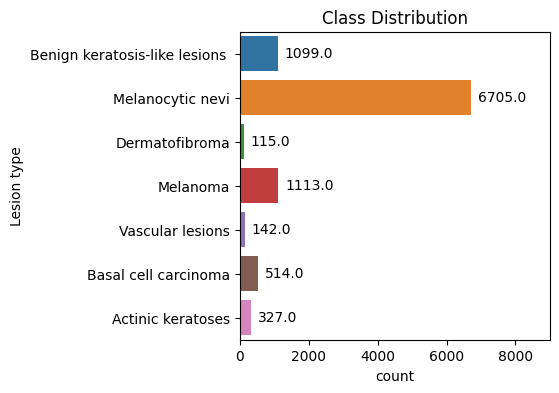


Most of the data is dominated by 'Melanocytic nevi'


In [51]:
plt.figure(figsize=(4,4))
ax = sns.countplot(data=df, y="cell_type", palette="tab10")
plt.title("Class Distribution")
plt.ylabel('Lesion type')
plt.xlim(0, 9000)
# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.show()
print("\n\033[1;32mMost of the data is dominated by 'Melanocytic nevi'")

In [ ]:
sns.histplot(data=df, x='age')

In [61]:
# Mapping the three classes in our datasets: Benign=0, Melanoma(Cancer)=1, Other Cancers/Pre cancerous=2)
df['target'] = 0 # Initialize all target values to 0 (Benign)
df.loc[df.dx == "mel", 'target'] = 1 # 1 for Melanoma
df.loc[df.dx.isin(['bcc','akiec']), 'target'] = 2 # 2 for Other Cancers/Pre cancerous
print(df.target.value_counts())

target
0    8061
1    1113
2     841
Name: count, dtype: int64


In [66]:
df['age'] = df.groupby('target')['age'].transform(lambda x: x.fillna(x.median()))

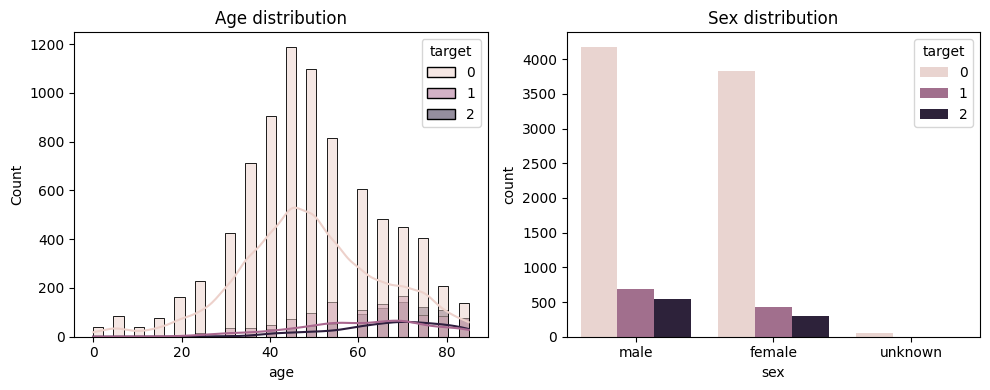


 Patients of age group from 40 and above are more susceptible


In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=df, x='age', kde=True, hue='target', ax=ax[0])
ax[0].set_title("Age distribution")
sns.countplot(data=df, x='sex', hue='target', ax=ax[1])
ax[1].set_title("Sex distribution")
plt.tight_layout()
plt.show()
print("\n\033[1;32m Patients of age group from 40 and above are more susceptible")

In [85]:
# Split train and validation dataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

### The Strategy: Metadata-Driven Image Augmentation


    1. **Preprocess Metadata**: Handle missing values and numerically encode categorical columns (sex, localization).
    2. **Apply SMOTE-NC**: Use SMOTE-NC on the metadata (age, sex, localization) to generate new, synthetic patient profiles for the minority classes.
    3. **Generate New Images**: For each synthetic patient profile, find a real image from the original dataset that has the same categorical features (class, sex, localization). Use this real image as a "template" to generate a new, augmented image.
    4. **Combine Datasets**: Create a final, balanced DataFrame containing the original data plus the new synthetic metadata and their corresponding newly generated images.





In [64]:
# Data Preparation

!pip install imbalanced-learn -q

In [86]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC

# encoding sex and localisation for SMOTENC
le_sex = LabelEncoder()
le_loc = LabelEncoder()

train_df['sex_encoded'] = le_sex.fit_transform(train_df['sex'])
train_df['localization_encoded'] = le_loc.fit_transform(train_df['localization'])

# Select multiple columns using a list
meta_x = train_df[['age', 'sex_encoded','localization_encoded']]
meta_y = train_df['target']

# Note: The SMOTENC fit method expects X and y as separate arguments
smote_nc = SMOTENC(categorical_features=[1,2], random_state=42)
res_x, res_y = smote_nc.fit_resample(meta_x,meta_y) # Use fit_resample

print("Original dataset shape:", meta_x.shape)
print("Resampled dataset shape:", res_x.shape)

# Convert the resampled data back to a DataFrame
meta_res_df = pd.DataFrame(res_x, columns=meta_x.columns)
meta_res_df['target'] = res_y
meta_res_df['sex_encoded'] = meta_res_df['sex_encoded'].round().astype(int)
meta_res_df['localization_encoded'] = meta_res_df['localization_encoded'].round().astype(int)

Original dataset shape: (8012, 3)
Resampled dataset shape: (19347, 3)


In [91]:
# generating synthetic images

import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

os.makedirs('synthetic_images', exist_ok=True)
augment_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
num_original = len(train_df)
df_synthetic_only = meta_res_df.iloc[num_original:].copy()
new_image_paths = []

print(f"Generating {len(df_synthetic_only)} new images...")

for index, row in tqdm(df_synthetic_only.iterrows(), total=len(df_synthetic_only)):

    template_pool = train_df[
        (train_df['target'] == row['target']) &
        (train_df['sex_encoded'] == row['sex_encoded']) &
        (train_df['localization_encoded'] == row['localization_encoded'])
    ]
    if template_pool.empty:
        template_pool = train_df['target'] == row['target']

    template_row = template_pool.sample(1).iloc[0]
    template_path = template_row['path']

    img = cv2.imread(template_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((1,) + img.shape)
    augmented_image = next(augment_gen.flow(img, batch_size=1))
    augmented_image = augmented_image.astype('uint8')[0]

    new_path = f"synthetic_images/synth_{index}.jpg"
    cv2.imwrite(new_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
    new_image_paths.append(new_path)

df_synthetic_only['path'] = new_image_paths
df_synthetic_only.dropna(inplace=True)


Generating 11335 new images...


100%|██████████| 11335/11335 [12:30<00:00, 15.11it/s]


In [95]:
df_final_train = pd.concat([train_df.copy(), df_synthetic_only], ignore_index=True)
df_final_train = df_final_train.sample(frac=1, random_state=42).reset_index(drop=True)
print("Final balanced dataset distribution:")
print(df_final_train['target'].value_counts())

Final balanced dataset distribution:
target
1    6449
0    6449
2    6449
Name: count, dtype: int64


1 Mel
2 Other


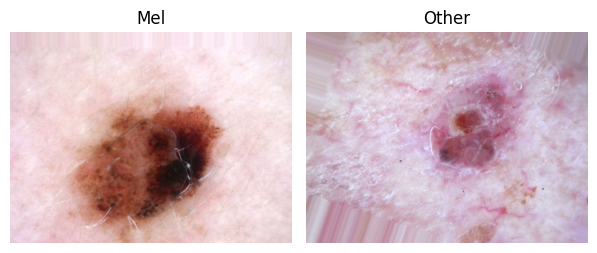

In [107]:
#Plotting the synthetic images
plt.figure(figsize=(12, 8)) # Increased figure size for better visualization
for i, cls in zip(range(1,3), ['Mel','Other']):
    print(i, cls)
    random_row = df_synthetic_only[(df_synthetic_only["target"]==i)].sample(n=1)
    image_path = random_row["path"].iloc[0]
    img = np.array(Image.open(image_path))
    plt.subplot(2,4, i+1)
    plt.imshow(img)
    plt.title(f"{cls}")
    plt.axis('off')
plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()